In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cic = pd.read_csv("Car_Insurance_Claim.csv")
cic.drop(columns=['Unnamed: 0', 'ID'], inplace=True)
to_num= cic.columns[[6,7,9,10,11,12,14,15,16,17]]
cic[to_num] = cic[to_num].apply(pd.to_numeric, errors='coerce')
to_replace = [col for col in cic.columns if col != 'EDUCATION']
cic['EDUCATION'] = cic['EDUCATION'].replace('none', 'unknown')
cic[to_replace] = cic[to_replace].replace('none', np.nan)
cic = cic.dropna(subset=[col for col in cic.columns if col not in ['ANNUAL_MILEAGE', 'CREDIT_SCORE']])
to_bool = ['OUTCOME','CHILDREN', 'MARRIED', 'VEHICLE_OWNERSHIP']
cic[to_bool] = cic[to_bool].astype(bool)
mean_mileage = cic.groupby(['VEHICLE_YEAR', 'VEHICLE_TYPE'])['ANNUAL_MILEAGE'].transform(lambda x: int(np.round(x.mean(), -3)))
cic['ANNUAL_MILEAGE'] = cic['ANNUAL_MILEAGE'].fillna(mean_mileage)
mean_credit = cic.groupby(['AGE', 'GENDER','INCOME'])['CREDIT_SCORE'].transform(lambda x: (x.mean()))
cic['CREDIT_SCORE'] = cic['CREDIT_SCORE'].fillna(mean_credit)
to_int = ['POSTAL_CODE','ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS','PAST_ACCIDENTS' ]
cic[to_int] = cic[to_int].astype(int)

print(cic.sample(5),"\n", cic.shape, '\n' )
print(cic.isnull().sum())

        AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION         INCOME  \
3330  40-64  female  majority               0-9y   university    upper class   
5305  26-39  female  majority               0-9y      unknown  working class   
1791    65+    male  majority             10-19y  high school    upper class   
7557  40-64  female  majority             20-29y   university    upper class   
4333    65+  female  majority             10-19y  high school    upper class   

      CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  CHILDREN  \
3330      0.727533               True  before 2015    False     False   
5305      0.602763               True   after 2015    False      True   
1791      0.445406               True  before 2015     True      True   
7557      0.679074               True   after 2015    False      True   
4333      0.623551              False  before 2015     True      True   

      POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  DUIS  \
333

In [25]:
def eda_summary(df):
    print("Загальний опис всіх колонок (числових і категоріальних):\n")
    print(df.describe(include='all'), '\n')
    
    print("Частоти значень по кожній колонці:\n")
    for col in df.columns:
        print(f"Колонка: {col}")
        print(df[col].value_counts(dropna=False))
        print("-" * 50)

    print("\nСтатистика лише для числових колонок:\n")
    print(df.describe())

    if 'OUTCOME' in df.columns:
        print("\nРозподіл цільової змінної 'OUTCOME':")
        print(df['OUTCOME'].value_counts())
eda_summary(cic)


Загальний опис всіх колонок (числових і категоріальних):

          AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION       INCOME  \
count    8662    8662      8662               8662         8662         8662   
unique      4       2         2                  4            3            4   
top     26-39  female  majority               0-9y  high school  upper class   
freq     2675    4351      7823               3072         3579         3733   
mean      NaN     NaN       NaN                NaN          NaN          NaN   
std       NaN     NaN       NaN                NaN          NaN          NaN   
min       NaN     NaN       NaN                NaN          NaN          NaN   
25%       NaN     NaN       NaN                NaN          NaN          NaN   
50%       NaN     NaN       NaN                NaN          NaN          NaN   
75%       NaN     NaN       NaN                NaN          NaN          NaN   
max       NaN     NaN       NaN                NaN          Na

In [29]:
# Копія датафрейму
cic_stat = cic.copy()

# Функція для підрахунку успішності
def success_rate(df, column):
    return df.groupby(column, observed=True)['OUTCOME'].mean() * 100

# Функція категоризації змінної
def categorize_and_replace(df, column, bins, labels):
    df.insert(df.columns.get_loc(column) + 1, f"{column}_GROUP", pd.cut(df[column], bins=bins, labels=labels))
    return df.drop(columns=[column])

# Параметри для категоризації
grouping_params = {
    'CREDIT_SCORE': ([-1, 0.25, 0.5, 0.75, float('inf')], ['Low', 'Medium', 'High', 'Very High']),
    'ANNUAL_MILEAGE': ([-1, 10000, 15000, float('inf')], ['Low', 'Medium', 'High']),
    'SPEEDING_VIOLATIONS': ([-1, 3, 8, float('inf')], ['Low', 'Medium', 'High']),
    'DUIS': ([-1, 1, 3, float('inf')], ['Low', 'Medium', 'High']),
    'PAST_ACCIDENTS': ([-1, 2, 5, float('inf')], ['Low', 'Medium', 'High']),
}

# Категоризація всіх змінних
for col, (bins, labels) in grouping_params.items():
    cic_stat = categorize_and_replace(cic_stat, col, bins, labels)

# Вивід успішності по кожній колонці
for col in cic_stat.columns:
    print(f"Success rate for '{col}' (%):\n", success_rate(cic_stat, col), "\n")


Success rate for 'AGE' (%):
 AGE
16-25    71.670429
26-39    33.532710
40-64    15.661207
65+       9.871495
Name: OUTCOME, dtype: float64 

Success rate for 'GENDER' (%):
 GENDER
female    26.476672
male      36.557643
Name: OUTCOME, dtype: float64 

Success rate for 'RACE' (%):
 RACE
majority    31.305126
minority    33.253874
Name: OUTCOME, dtype: float64 

Success rate for 'DRIVING_EXPERIENCE' (%):
 DRIVING_EXPERIENCE
0-9y      62.792969
10-19y    23.990251
20-29y     5.143805
30y+       1.868132
Name: OUTCOME, dtype: float64 

Success rate for 'EDUCATION' (%):
 EDUCATION
high school    32.355407
university     22.692308
unknown        47.152085
Name: OUTCOME, dtype: float64 

Success rate for 'INCOME' (%):
 INCOME
middle class     27.856366
poverty          65.320075
upper class      13.447629
working class    44.736842
Name: OUTCOME, dtype: float64 

Success rate for 'CREDIT_SCORE_GROUP' (%):
 CREDIT_SCORE_GROUP
Low          56.118143
Medium       47.206385
High         19.415404

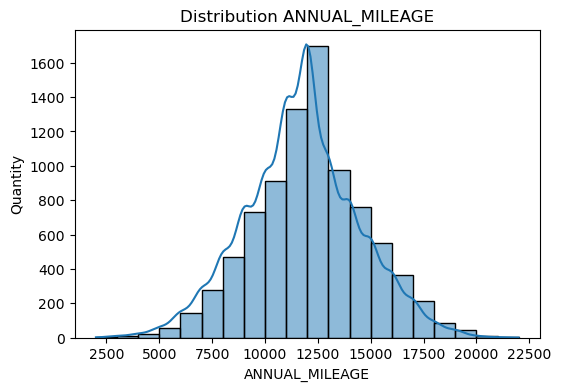

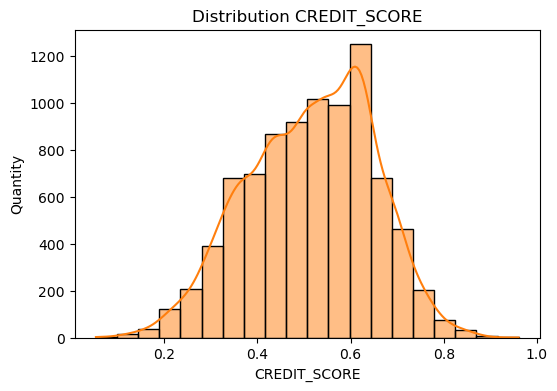

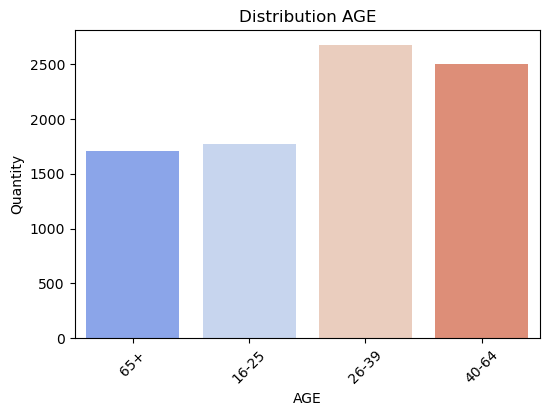

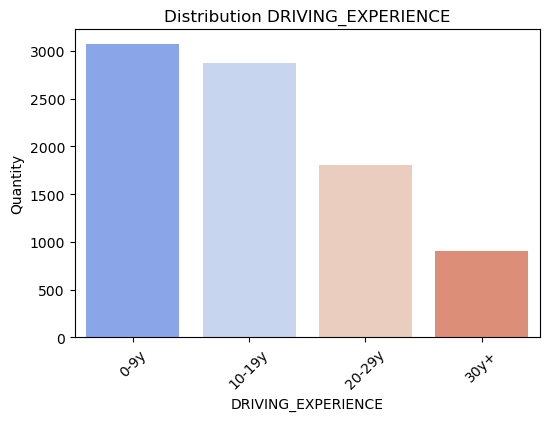

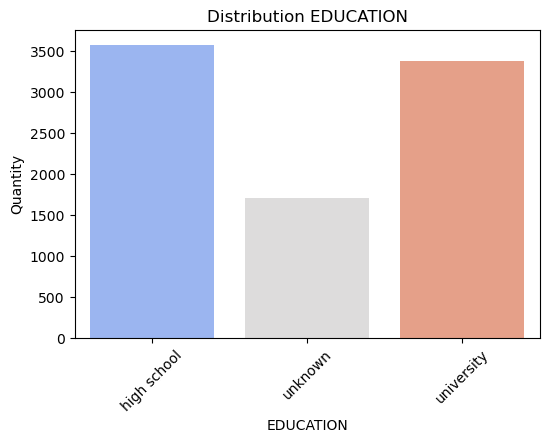

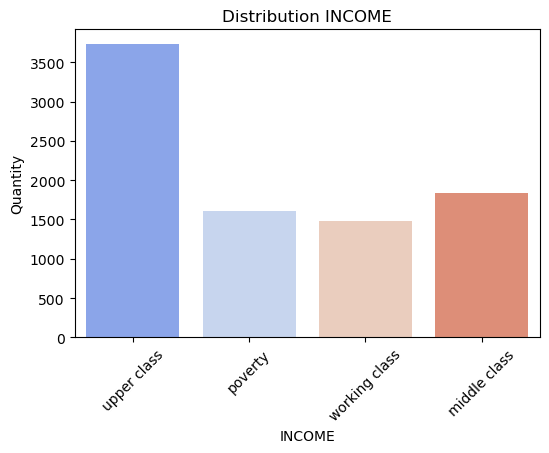

In [35]:
def plot_variable(df, column, bins=20, color='blue'):
  
    plt.figure(figsize=(6, 4))
    
    if df[column].dtype == 'object' or df[column].nunique() < 10:  
        sns.countplot(x=df[column], palette='coolwarm', hue=df[column])
        plt.xticks(rotation=45)  
    else:  
        sns.histplot(df[column], bins=bins, kde=True, color=color)

    plt.title(f'Distribution {column}')
    plt.xlabel(column)
    plt.ylabel('Quantity')
    plt.show()

plot_variable(cic, 'ANNUAL_MILEAGE', color='#1f77b4')   # синій
plot_variable(cic, 'CREDIT_SCORE', color='#ff7f0e')     # помаранчевий
plot_variable(cic, 'AGE', color='#2ca02c')              # зелений
plot_variable(cic, 'DRIVING_EXPERIENCE', color='#d62728')  # червоний
plot_variable(cic, 'EDUCATION', color='#9467bd')        # фіолетовий
plot_variable(cic, 'INCOME', color='#8c564b') 


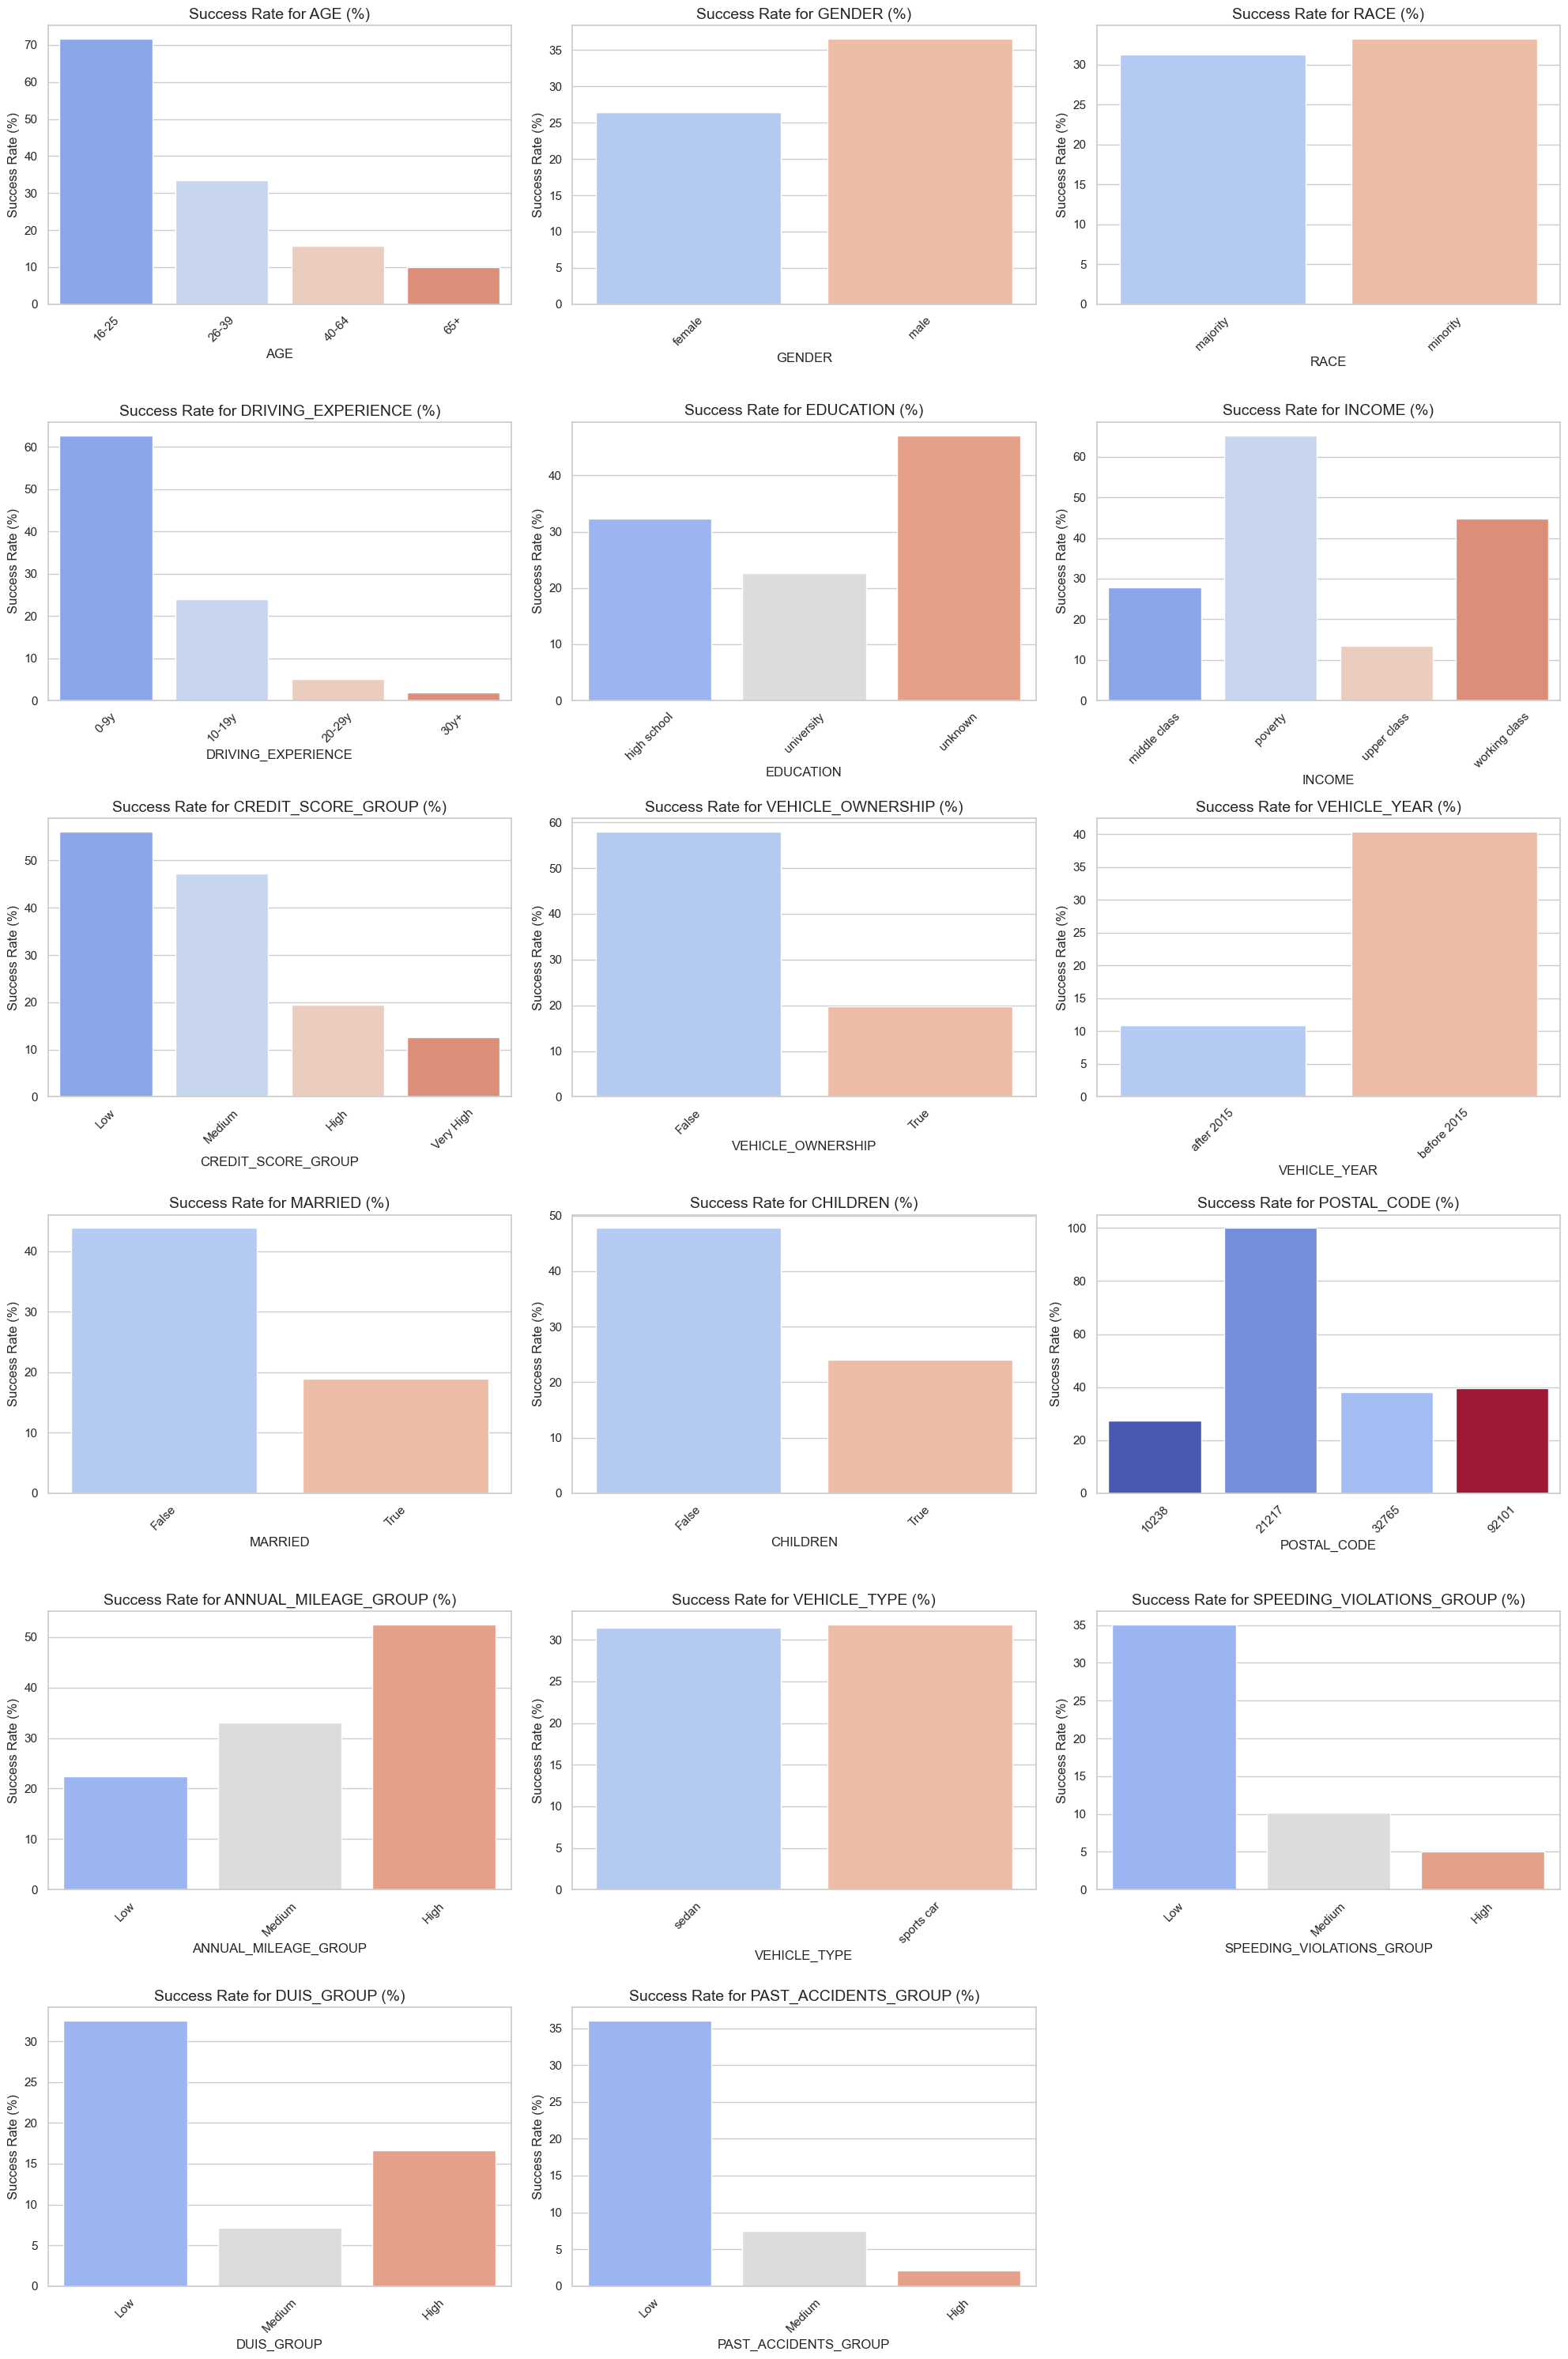

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Налаштування стилю та розміру
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (20, 30)

# Обчислення кількості колонок і рядків для підграфіків
num_cols = len(cic_stat.columns) - 1
num_rows = (num_cols + 2) // 3

# Створення фігури та осей
fig, axes = plt.subplots(num_rows, 3, figsize=(20, 5 * num_rows))
axes = axes.flatten()

# Функція для візуалізації успішності по стовпцю
def visualize_success_rate_on_axes(df, column, ax):
    success_rates = success_rate(df, column)
    
    # Використання кольорових схем для barplot
    sns.barplot(
        x=success_rates.index,
        y=success_rates.values,
        palette="coolwarm",  # Змінив кольорову палітру
        ax=ax,
        hue=success_rates.index,
        legend=False
    )
    
    ax.set_title(f'Success Rate for {column} (%)', fontsize=14)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Success Rate (%)', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

# Візуалізація успішності для кожної колонки
for i, col in enumerate([col for col in cic_stat.columns if col != 'OUTCOME']):
    visualize_success_rate_on_axes(cic_stat, col, axes[i])

# Вимкнення непотрібних осей
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Автоматичне налаштування розмірів
plt.tight_layout()
plt.show()


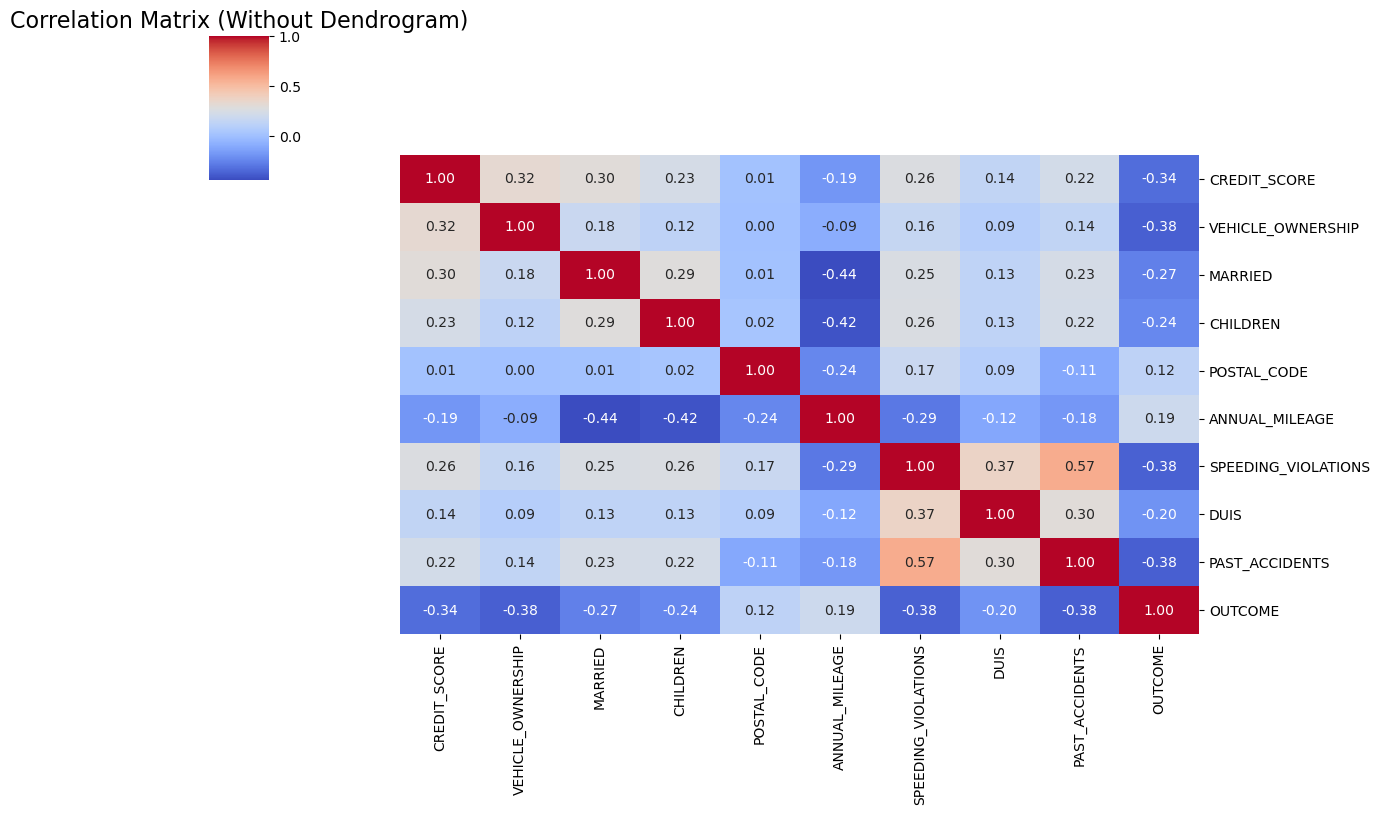

In [47]:
# Кореляційна матриця для вибраних числових колонок
corr_df = cic.iloc[:,[6,7,9,10,11,12,14,15,16,17]].corr(method='spearman')

# Візуалізація без ліній дерева (без кластеризації)
sns.clustermap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0, figsize=(12, 8), 
               row_cluster=False, col_cluster=False)
plt.title("Correlation Matrix (Without Dendrogram)", fontsize=16)
plt.show()


## **Conclusions**

Firstly, you categorized certain numerical columns, which simplifies data analysis and visualization. For example, columns like `CREDIT_SCORE`, `ANNUAL_MILEAGE`, `SPEEDING_VIOLATIONS`, `DUIS`, and `PAST_ACCIDENTS` were transformed into categories (such as "Low", "Medium", "High"). This categorization makes the analysis easier by allowing you to examine data in distinct groups, making comparisons of success across different categories more intuitive.

Secondly, you calculated and visualized the success rate for each column using bar plots. This helps to understand how the target variable (`OUTCOME`) is dependent on various features. The success rate for each column shows how different values or categories correlate with outcomes, providing valuable insights into which features may be useful for predicting success.

Furthermore, the correlation matrix allows you to visualize the relationships between different numerical features in your dataset. This helps identify positive or negative correlations between variables, which can affect model selection and feature importance. The heatmap you created clearly shows these correlations, making it easy to detect highly correlated variables that might be redundant in models.

Using various visualization types, such as bar plots and histograms, helps to interpret complex data, providing both an overview and a detailed analysis of specific aspects. These tools allow for a better understanding of the distribution of numerical features like `AGE`, `INCOME`, and `DRIVING_EXPERIENCE`, as well as identifying potential anomalies or outliers that may not be obvious at first glance.

Your approach enables easy adaptation of the analysis to other datasets or configurations by adding new features or adjusting the number of bins, labels, or color palettes to improve visual interpretation. This gives a high level of flexibility in adjusting analysis parameters and helps to obtain more accurate results for different scenarios.

Although not directly mentioned in the code, handling missing values might be an essential part of the analysis. If your dataset contains missing values, applying imputation or removal methods would be recommended to achieve more accurate results.

Thus, categorizing numerical features and visualizing their success rate significantly simplifies data analysis. The correlation matrix helps assess relationships between different variables, while bar plots make it clear how features impact the target variable. Visualization and adjusting analysis parameters allow tailoring results to specific needs, providing valuable insights from your data.
